### get svg points array from csv

In [6]:
csv_name = "./isolated.csv"

In [7]:
import numpy as np

csv_path = csv_name


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


paths = read_csv(csv_path)
print(paths)

[[array([[109.14299774, 125.58000183],
       [110.15747833, 125.49578094],
       [111.17194366, 125.40398407],
       [112.18638611, 125.30522156],
       [113.20079041, 125.20011139],
       [114.21517181, 125.08926392],
       [115.22950745, 124.97328949],
       [116.2437973 , 124.85279083],
       [117.25804138, 124.72838593],
       [118.27222443, 124.60068512],
       [119.28635406, 124.47029877],
       [120.30041504, 124.33782959],
       [121.31440735, 124.2039032 ],
       [122.32831573, 124.06912231],
       [123.34214783, 123.93410492],
       [124.355896  , 123.79945374],
       [125.36954498, 123.66577911],
       [126.38310242, 123.53369141],
       [127.39655304, 123.40380859],
       [128.40989685, 123.27674103],
       [129.42312622, 123.15309143],
       [130.43623352, 123.03347778],
       [131.44923401, 122.91851044],
       [132.46208191, 122.80879974],
       [133.47480774, 122.70494843],
       [134.48739624, 122.60758209],
       [135.49983215, 122.51730347],

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Create spline interpolation of the data


if x.ndim == 0:
    x = np.expand_dims(x, axis=0)
if y.ndim == 0:
    y = np.expand_dims(y, axis=0)

if len(x) < 3 or len(y) < 3:
    print("x and y must have at least 3 points for spline interpolation")

sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

X_Y_Spline = make_interp_spline(x, y)

# Generate evenly spaced numbers over the specified interval
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

# Plotting the graph
plt.plot(X_, Y_)
plt.title("Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

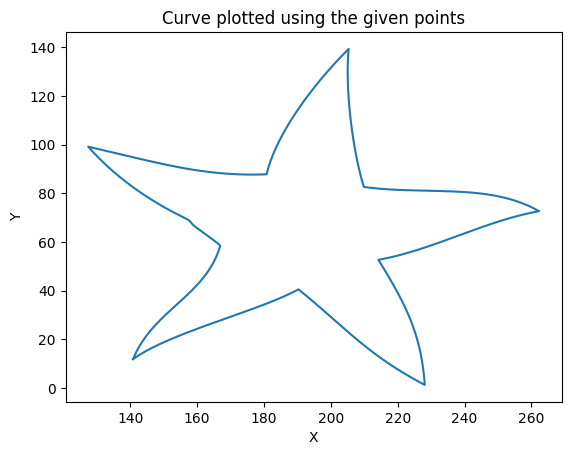

In [63]:
import numpy as np
import matplotlib.pyplot as plt

x, y = [], []
for path_XY in paths:
    for XY in path_XY:
        x.append(XY[:, 0])
        y.append(XY[:, 1])

x = np.array(x[1])
y = np.array(y[1])


plt.plot(x, y)
plt.title("Curve plotted using the given points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

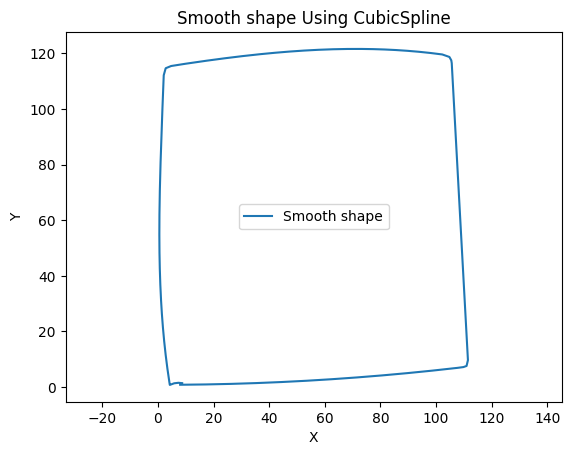

In [156]:
import numpy as np
# from scipy.interpolate import CubicSpline
import bezier
import matplotlib.pyplot as plt

# Generate points on a circle
# if x[0] != x[-1] or y[0] != y[-1]:
#     x = np.append(x, x[0])
#     y = np.append(y, y[0])
nodes = np.asfortranarray([x, y])

# Create a Bézier curve from the nodes
curves = []
for i in range(len(x) - 1):
    segment_nodes = nodes[:, i:i+2]
    curve = bezier.Curve(segment_nodes, degree=1)
    curves.append(curve)


# Evaluate the curve at num_points equally spaced intervals
s_vals = np.linspace(0.0, 1.0, 500)
points = curve.evaluate_multi(s_vals)

x_new = np.array([])
y_new = np.array([])
for curve in curves:
    points = curve.evaluate_multi(s_vals)
    x_new = np.append(x_new, points[0, :])
    y_new = np.append(y_new, points[1, :])

# Plot the original points and the interpolated smooth curve
plt.plot(x_new, y_new, label=f'Smooth shape')
# plt.scatter(x, y, color='red', label=f'Original shape Points')
plt.title(f"Smooth shape Using CubicSpline")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.show()


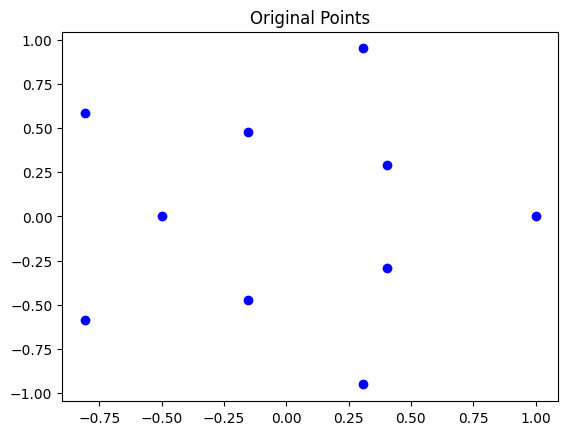

Trying eps=0.5, min_samples=5: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=3: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=1: Original points: 10, Cleaned points: 10


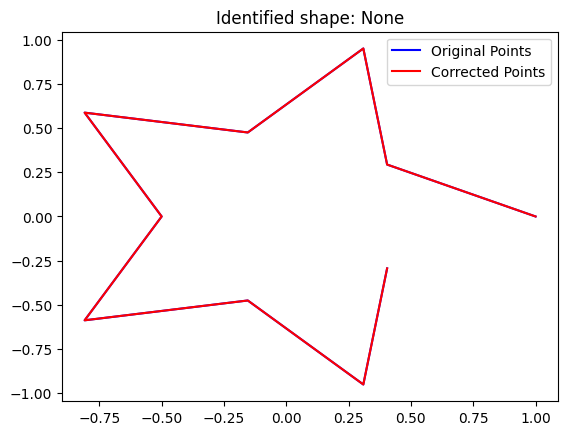

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

def preprocess(points, eps_values=[0.5, 1.0, 1.5], min_samples_values=[5, 3, 1]):
    """Preprocess the input points to remove noise using DBSCAN with different parameters."""
    for eps in eps_values:
        for min_samples in min_samples_values:
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
            labels = clustering.labels_
            cleaned_points = points[labels != -1]
            print(f"Trying eps={eps}, min_samples={min_samples}: Original points: {len(points)}, Cleaned points: {len(cleaned_points)}")
            if len(cleaned_points) > 0:
                return cleaned_points
    raise ValueError("No points left after preprocessing with any parameter combination.")

def extract_features(points):
    """Extract shape features for identification."""
    if len(points) == 0:
        raise ValueError("No points given after preprocessing.")
    
    hull = ConvexHull(points)
    perimeter = hull.area
    area = hull.volume

    # Calculate centroid
    M = cv2.moments(points)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])

    # Calculate circularity
    circularity = 4 * np.pi * area / (perimeter ** 2)

    features = {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'centroid': (cx, cy),
        'hull_points': points[hull.vertices]
    }
    return features

def identify_shape(features):
    """Identify the shape based on extracted features."""
    circularity = features['circularity']
    hull_points = features['hull_points']

    # Basic thresholds for shape classification
    if circularity > 0.75:
        shape_label = "circle"
    elif len(hull_points) == 3:
        shape_label = "triangle"
    elif len(hull_points) == 4:
        # Check for square/rectangle by comparing sides
        side_lengths = np.linalg.norm(np.diff(hull_points, axis=0), axis=1)
        side_lengths = np.append(side_lengths, np.linalg.norm(hull_points[0] - hull_points[-1]))
        if np.std(side_lengths) < 0.1 * np.mean(side_lengths):
            shape_label = "square"
        else:
            shape_label = "rectangle"
    else:
        # Check for star shape with tolerance
        angles = []
        for i in range(len(features['hull_points'])):
            p1 = features['hull_points'][i]
            p2 = features['hull_points'][(i + 1) % len(features['hull_points'])]
            p3 = features['hull_points'][(i + 2) % len(features['hull_points'])]
            v1 = p2 - p1
            v2 = p3 - p2
            angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angles.append(angle)
        angles = np.array(angles)

        # Allow for some tolerance in angle variations
        inner_angle_tol = np.pi / 6  # Adjust tolerance as needed
        outer_angle_tol = np.pi / 3  # Adjust tolerance as needed
        if np.all((angles > inner_angle_tol) & (angles < np.pi - outer_angle_tol)):
            shape_label = "star"
        else:
            shape_label = "unknown"

def correct_shape(points, shape_label):
    """Correct the shape based on the identified shape."""
    if shape_label == "circle":
        # Ensure points are in the correct format
        points = np.array(points, dtype=np.float32)
        # Fit a circle
        (x, y), radius = cv2.minEnclosingCircle(points)
        theta = np.linspace(0, 2 * np.pi, len(points))
        corrected_points = np.c_[x + radius * np.cos(theta), y + radius * np.sin(theta)]
    elif shape_label == "triangle" or shape_label == "square" or shape_label == "rectangle":
        hull = ConvexHull(points)
        corrected_points = points[hull.vertices]
    else:
        corrected_points = points

    return corrected_points

def main(points):
    # Visualize original points
    plt.scatter(points[:, 0], points[:, 1], label="Original Points", color='blue')
    plt.title("Original Points")
    plt.show()

    cleaned_points = preprocess(points)
    if len(cleaned_points) == 0:
        raise ValueError("No points left after preprocessing.")
    
    features = extract_features(cleaned_points)
    shape_label = identify_shape(features)
    corrected_points = correct_shape(cleaned_points, shape_label)

    # Visualization
    plt.plot(points[:, 0], points[:, 1], label="Original Points", color='blue')
    plt.plot(corrected_points[:, 0], corrected_points[:, 1], label="Corrected Points", color='red')
    plt.title(f"Identified shape: {shape_label}")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Sample points (replace with your data)
    points = np.vstack((x, y)).T

    main(points)

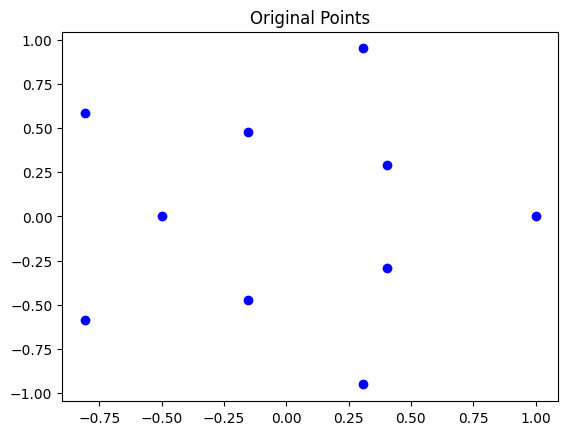

Trying eps=0.5, min_samples=5: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=3: Original points: 10, Cleaned points: 0
Trying eps=0.5, min_samples=1: Original points: 10, Cleaned points: 10


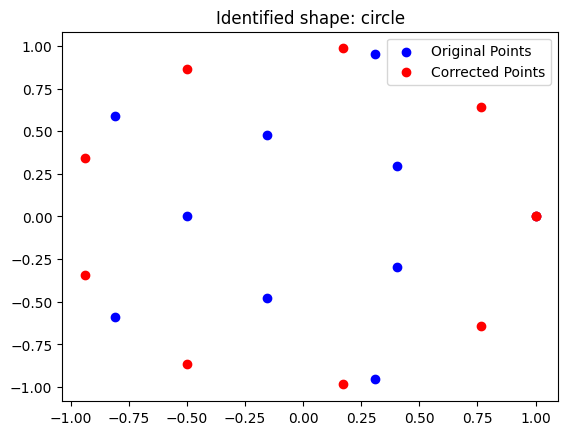

In [73]:
import svgwrite
import cairosvg


def polylines2svg(
    paths_XYs,
    svg_path,
    colours=["yellow"],
):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile="tiny", shape_rendering="crispEdges")
    group = dwg.g()
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            # if not np.allclose(XY[0], XY[-1]):
            #     path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill="none", stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace(".svg", ".png")
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color="white",
    )
    return


polylines2svg(paths, "test.svg")

In [1]:
import os

os.environ["path"] += r"C:\Program Files\GTK3-Runtime Win64\bin"

In [2]:
import numpy as np
print(np.__version__)

2.0.1


In [3]:
import cv2
print(cv2.__version__)

4.10.0


### import opencv and initialization

In [37]:
import numpy as np
import cv2  # Only for displaying results, not for shape detection

def detect_shapes(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define color thresholds (adjust as needed)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Create masks
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Find contours (connected components)
    contours, _ = cv2.findContours(mask_yellow, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)

        # Calculate area to filter out small contours
        area = cv2.contourArea(cnt)
        if area < 500:  # Adjust threshold as needed
            continue

        if len(approx) == 4:
            shape = "square"
            # Draw a green square border
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        elif len(approx) > 4 and area > 1000:  # Filter out small circles
            shape = "circle"
            # Draw a blue circle border
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(img, center, radius, (255, 0, 0), 2)
        else:
            shape = "unknown"

        # Draw label
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.putText(img, shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.namedWindow('Shapes', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Shapes', 600, 600)
    cv2.imshow("Shapes", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
image_path = "test.png"
detect_shapes(image_path)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Disha Shah\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import